In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import gym
import gym_combrf

import numpy as np
import random
import math
import matplotlib.pyplot as plt
import tqdm
import os

import torch
import torch.optim as optim
import torch.nn.functional as F

import tqdm
from tqdm import tnrange, tqdm_notebook
from time import sleep
import os


In [13]:
#initialize gym environment
env = gym.make('combrf-v0')

In [14]:
#hyper-parameters
UPDATE_EVERY = 50 #how often to update the network
EPS_START = 1
EPS_END = 0.01
EPS_DECAY = 0.9983
EPS_STEP_LIMIT = 50

TRAIN_EPISODES = 20
TEST_EPISODES = 1
seed = 0

#initialize GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


## Examine state and action spaces

In [15]:
#reset the environment
obs = env.reset()

#size of each action
action_size = env.action_space.shape
print("Size of each action: ", action_size)

#size of observation
print("Size of each observation: ", obs.shape)
print("Observation looks like:")
print(obs)
print(type(env.action_space.sample()))

Size of each action:  (1,)
Size of each observation:  (1, 4)
Observation looks like:
[[-1.48197136e-07 -8.24293780e-07  1.26666667e+00  8.00000000e-01]]
<class 'numpy.ndarray'>


## Perform random actions in the environment

In [16]:
obs = env.reset()
count = 0
ep_rwd=0
rewards =[]
actions =[]
while True:
    action = np.array([[np.random.uniform(0,1)]])
    obs, rwd, done, _ = env.step(action)
    ep_rwd += rwd
    rewards.append(rwd)
    actions.append(action)
    count +=1
    if done:
        break
print("Random TX location: {0}".format(env.tx_loc))
print("Capacity: {0}".format(env.cap))
print("Episodic score: {0} with episode length: {1} ".format(ep_rwd, count))
print(rewards)
print(actions)

Random TX location: [[ 50 400   0]]
Capacity: 4.58303301928599e-08
Episodic score: 3.0 with episode length: 9 
[1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0]
[array([[0.52985943]]), array([[0.73979658]]), array([[0.30822571]]), array([[0.72348285]]), array([[0.84490128]]), array([[0.8473643]]), array([[0.57362247]]), array([[0.10171311]]), array([[0.10259758]])]


## Instantiate DDPG agent

In [17]:
#import custom classes
from Source.ddpg_rcv_agent import Agent
from Source.nn_model import Actor, Critic
from Source.ddpg_rcv_agent import Agent, ReplayBuffer, OUNoise
from Source.misc_fun.utils import get_moving_average, plot
from collections import deque

#reset the environment
obs = env.reset()

state_size = obs.shape[1]
action_size = env.action_space.shape[0]
print(env.action_space.shape)
print(state_size)
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
print("Actor Local Network: {}".format(agent.actor_local))
print("Actor Target Network: {}".format(agent.actor_target))
print("Critic Local Network: {}".format(agent.critic_local))
print("Critic Target Network: {}".format(agent.critic_target))

print(type(obs))
obs_tensor = torch.from_numpy(obs).float().to(device)
print(obs_tensor)

(1,)
4
Actor Local Network: Actor(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Actor Target Network: Actor(
  (fc1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=400, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Critic Local Network: Critic(
  (fcs1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=401, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
Critic Target Network: Critic(
  (fcs1): Linear(in_features=4, out_features=400, bias=True)
  (fc2): Linear(in_features=401, out_features=300, bias=True)
  (fc3): Linear(in_features=300, out_features=1, bias=True)
)
<class 'numpy.ndarray'>
tensor([[-1.1029e-07, -1.9018e-07,  8.6667e-01,  6.0000e-01]], device='cuda:0')


In [18]:
agent.reset()

In [19]:
obs = env.reset()

print(env.action_space.sample())
action = agent.act(obs)
print(action)

[3.7338183]
[[0.21403219]]


## DDPG Training

c:\pycharm_workspace\precoding_rl\venv\lib\site-packages\ipykernel_launcher.py:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  after removing the cwd from sys.path.


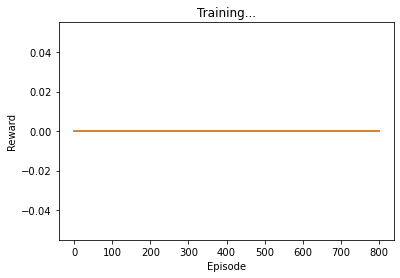

In [20]:
train_episodes = 800
print_every= 100

outer = tqdm.tqdm_notebook(total=train_episodes, desc='training loop: ', position=0)

scores_deque = deque(maxlen=print_every)
scores = []
ep_qvals =[]
ep_rwds = []
timestep = 0

for i_episode in range(1,train_episodes+1):
    
    # reset the environment
    obs = env.reset()
    agent.reset()
    
    ep_actions =[]
    ep_env_actions =[]
    score = 0
    ep_qval = 0
    while True:
        action = agent.act(obs)
        next_obs, reward, done, _ = env.step(action)
        agent.step(obs, action, reward, next_obs, done)
        obs = next_obs
        score+= reward
        timestep+=1
        
        agent.critic_local.eval()
        obs_tensor = torch.from_numpy(obs).float().to(device)
        action_tensor = torch.from_numpy(action).float().to(device)
        #print(agent.critic_local(obs_tensor, action_tensor).cpu().data.item())
        ep_qval += agent.critic_local(obs_tensor, action_tensor).cpu().data.item()
        agent.critic_local.train()
        
       
        ep_actions.append(action)
        ep_env_actions.append(env.action)
        #ep_old_actions.append(agent.old_action)
        if done:
            ep_rwds.append(reward)
            moving_avg_rwd = get_moving_average(50, ep_rwds)
            print('\rEpisode {},\tScore: {:.2f}, moving avg_rwd: {}'.format(i_episode, score, moving_avg_rwd[-1]), end="\r")
            break
            
    scores_deque.append(score)
    scores.append(score)
    ep_qvals.append(ep_qval)
    #print('\rEpisode {}\t, TX loc: {}\t, Score: {:.2f}\n'.format(i_episode, env.tx_loc, score), end="")
    
    #print(ep_rwds)
    #if i_episode % print_every == 0:
    #    print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, np.mean(scores_deque)))
    #    #print("Episode old_actions: {}".format(ep_old_actions))
    #    print("Episode actions: {}".format(ep_actions))
    #    print("Episode env actions: {}".format(ep_env_actions))
    
    # update tqdm bar
    outer.update(1)
        
#torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
#torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')    
agent.save_checkpoint(timestep)
#plot(ep_rwds, 200)

#fig = plt.figure()
#ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores)
#plt.ylabel('Score')
#plt.xlabel('Episode #')

#ax2 = fig.add_subplot(122)
#plt.plot(scores, ep_qvals)
#plt.ylabel('Episode Qvals')
#plt.xlabel('Episode Rewards')
#plt.show() 

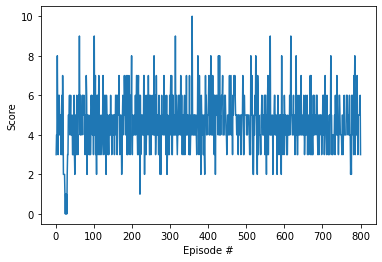

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()


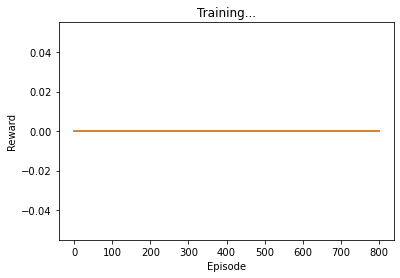

In [25]:
plot(ep_rwds, 20)

## Testing the DDPG agent

In [21]:
#instantiate the agent
agent = Agent(state_size=state_size, action_size=action_size, seed=0)
#agent.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
#agent.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))

agent.load_checkpoint(timestep)

score = 0.0
eps_rwd =[]
test_obs =[]
obs = env.reset()

agent.actor_local.eval()
agent.critic_local.eval()
agent.actor_target.eval()
agent.critic_target.eval()

ep_actions =[]
ep_old_actions =[]
tx_dirs =[]
rx_dirs=[]
data_rates =[]
done = False
while True:
    #obs_tensor = torch.from_numpy(obs).float().to(device)
    
    #with torch.no_grad():
    #    action =agent.actor_local(obs_tensor).cpu().data.numpy()
        #print("old_action: {}", action)
    #    best_action = agent.critic_local(obs_tensor)
    test_obs.append(obs)
    action =  agent.act(obs,add_noise=False)#.cpu().data.numpy()
    #action == np.clip(action, 0, 2*np.pi)
    
    #action_tensor = agent.actor_local(obs_tensor).to(device)
    #print(obs, action)
    #q_val = agent.critic_local(obs_tensor, action_tensor).cpu().data.numpy()
    tx_dirs.append(env.tx_bdir)
    rx_dirs.append(env.rx_bdir)
    data_rates.append(env.rate)
    
    if done:
        break
    obs, rwd, done, _ = env.step(action)
    
    score +=rwd
    eps_rwd.append(rwd)
    
    
print("TX loc: {0}".format(env.tx_loc))
print("TX dir: {}".format([x*(180/np.pi) for x in tx_dirs]))
print("RX dirs: {}".format([x*(180/np.pi) for x in rx_dirs]))
print("eps rwds: {}\n".format(eps_rwd))

TX loc: [[400  50   0]]
TX dir: [112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5, 112.5]
RX dirs: [259.6544497512104, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
eps rwds: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]



In [22]:
print(test_obs)

[array([[ 2.04142301e-07, -1.53428754e-07,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]]), array([[ 1.17981347e-06, -2.04806654e-06,  1.20000000e+00,
         7.33333333e-01]])]


3.2659476481365544
0.0


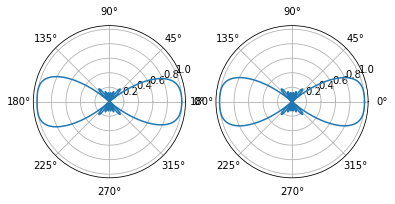

In [23]:
from Source.misc_fun.utils import plotbeam
print(env.channel.az_aod[0])
print(rx_dirs[-1])
tx_theta, tx_gr = plotbeam(env.channel.az_aod[0], env.N_tx)
rx_theta, rx_gr = plotbeam(rx_dirs[-1], env.N_rx)
ax1 = plt.subplot(121, projection='polar')
ax1.plot(tx_theta, tx_gr)

ax2 = plt.subplot(122, projection='polar')
ax2.plot(rx_theta, rx_gr)

plt.show()
